# Student Stress Level Classification: Comprehensive EDA and Modeling

## 1. Problem Description and Context
In the modern academic landscape, student stress is a growing concern that affects mental health, academic performance, and overall well-being. Identifying the root causes and predicting stress levels can enable timely interventions by educators and counselors.

This project aims to analyze a dataset of student stress factors to:
1.  **Understand** the key drivers of stress (psychological, physiological, environmental, academic, and social).
2.  **Predict** the stress level of a student based on these factors.

The dataset used is `StressLevelDataset.csv`, which contains various features grouped into five categories:
*   **Psychological**: Anxiety, Self-esteem, Depression, Mental health history.
*   **Physiological**: Headache, Blood pressure, Sleep quality, Breathing anomalies.
*   **Environmental**: Noise level, Living conditions, Safety, Basic needs.
*   **Academic**: Performance, Study load, Teacher-student relationship, Future career concerns.
*   **Social**: Social support, Peer pressure, Extracurricular activities, Bullying.

The target variable is `stress_level` (0: Low/Eustress, 1: Medium/Distress, 2: High/Stress).


## 2. Setup and Data Loading
We start by importing the necessary libraries and configuring the environment for visualization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Configuration for prettier plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('../StressLevelDataset.csv')
print(f"Dataset Shape: {df.shape}")
df.head()


Dataset Shape: (1100, 21)


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


## 3. Data Quality Check and Cleaning
Before analyzing, we must ensure the data is clean. We will check for:
1.  Missing values.
2.  Duplicate rows.
3.  Data types.


In [3]:
# 1. Missing Values
print("Missing Values per Column:")
print(df.isnull().sum())

# 2. Duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")

# 3. Data Types
print("\nData Types:")
print(df.dtypes)

# 4. Summary Statistics
print("\nSummary Statistics:")
df.describe().T


Missing Values per Column:
anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

Number of Duplicate Rows: 0

Data Types:
anxiety_level                   int64
self_esteem                     int64
mental_health_history           int64
depression                      int64
headache                        int64
blood_pressure

,count,mean,std,min,25%,50%,75%,max
anxiety_level,1100.0,11.063636,6.117558,0.0,6.0,11.0,16.0,21.0
self_esteem,1100.0,17.777273,8.944599,0.0,11.0,19.0,26.0,30.0
mental_health_history,1100.0,0.492727,0.500175,0.0,0.0,0.0,1.0,1.0
depression,1100.0,12.555455,7.727008,0.0,6.0,12.0,19.0,27.0
headache,1100.0,2.508182,1.409356,0.0,1.0,3.0,3.0,5.0
blood_pressure,1100.0,2.181818,0.833575,1.0,1.0,2.0,3.0,3.0
sleep_quality,1100.0,2.660000,1.548383,0.0,1.0,2.5,4.0,5.0
breathing_problem,1100.0,2.753636,1.400713,0.0,2.0,3.0,4.0,5.0
noise_level,1100.0,2.649091,1.328127,0.0,2.0,3.0,3.0,5.0
living_conditions,1100.0,2.518182,1.119208,0.0,2.0,2.0,3.0,5.0


**Observation:**
- **Clean Data:** The dataset has no missing values and no duplicate rows.
- **Class Balance:** The target variable `stress_level` is evenly distributed (~33% for each class), which is excellent for model training as it negates the need for resampling techniques like SMOTE.


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Variable Distribution
Let's examine the distribution of the `stress_level` target variable to check if the dataset is balanced.


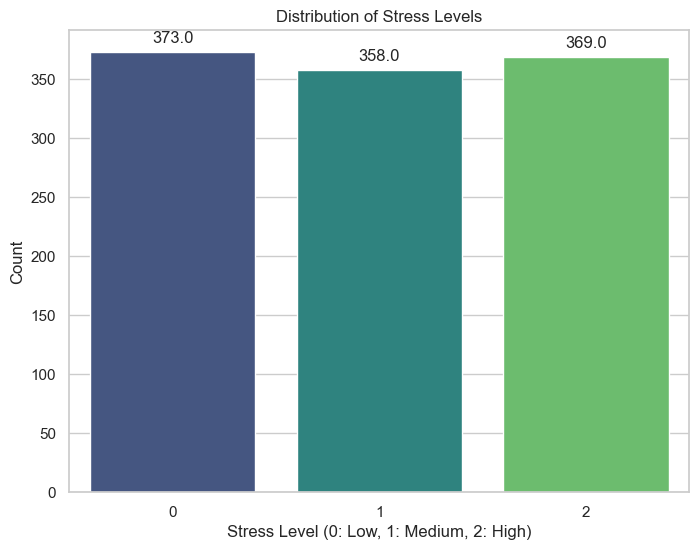

stress_level
0    0.339091
2    0.335455
1    0.325455
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='stress_level', data=df, palette='viridis')
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level (0: Low, 1: Medium, 2: High)')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

# Calculate proportions
print(df['stress_level'].value_counts(normalize=True))


### 4.2 Feature Distributions
We analyze the distribution of key physiological and psychological features.


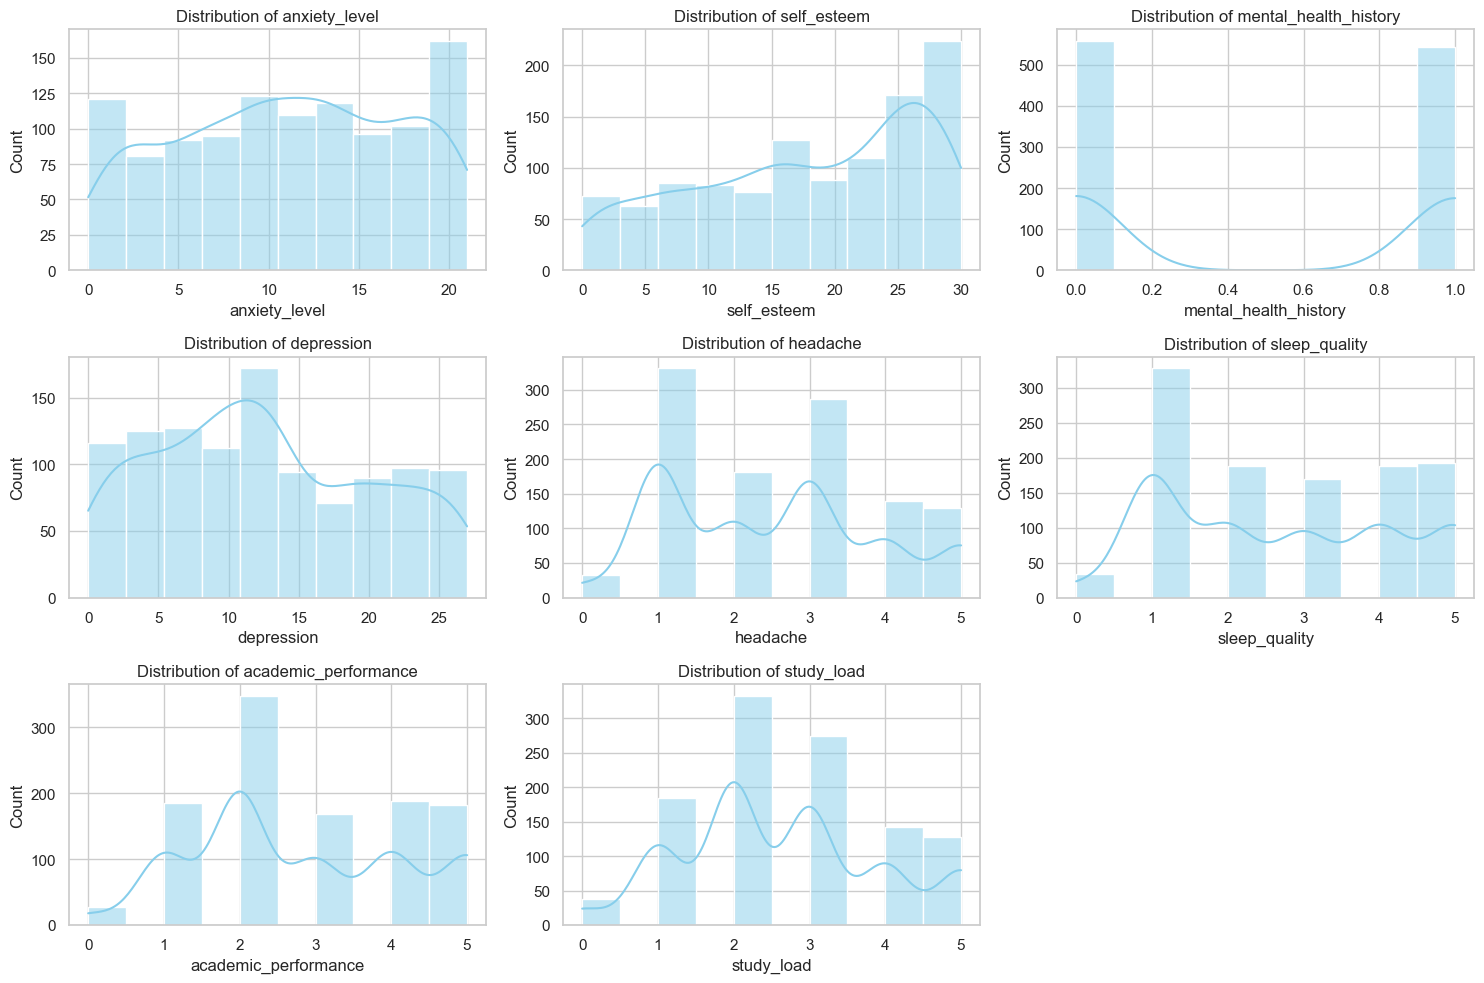

In [5]:
# Select a subset of features to visualize
features_to_plot = ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'sleep_quality', 'academic_performance', 'study_load']

plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=10, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()


### 4.3 Correlation Analysis
We examine the Pearson correlation coefficients to identify linear relationships.

**Key Findings:**
*   **Positive Correlations:** `bullying` (0.75), `anxiety_level` (0.74), and `depression` (0.73) are the strongest stressors.
*   **Negative Correlations:** `self_esteem` (-0.76), `sleep_quality` (-0.75), and `safety` (-0.71) are strong protective factors.


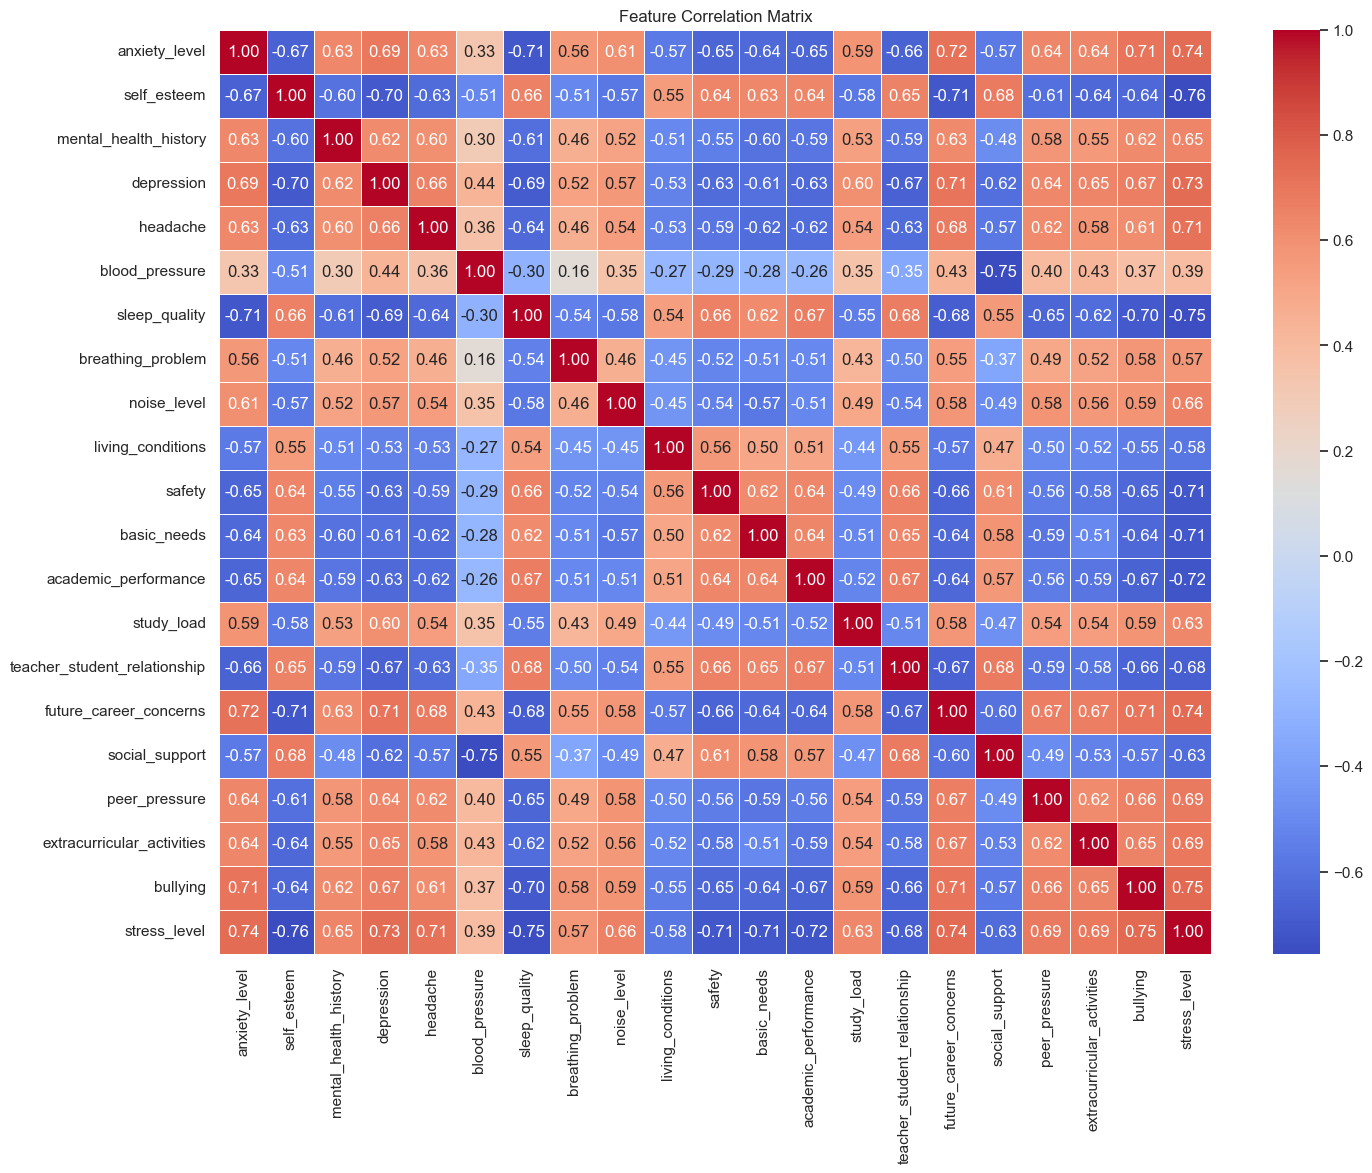

Top 10 features most correlated with Stress Level:
stress_level                  1.000000
bullying                      0.751162
future_career_concerns        0.742619
anxiety_level                 0.736795
depression                    0.734379
headache                      0.713484
extracurricular_activities    0.692977
peer_pressure                 0.690684
noise_level                   0.663371
mental_health_history         0.648644
Name: stress_level, dtype: float64

Top 10 features negatively correlated with Stress Level:
self_esteem                    -0.756195
sleep_quality                  -0.749068
academic_performance           -0.720922
safety                         -0.709602
basic_needs                    -0.708968
teacher_student_relationship   -0.680163
social_support                 -0.632497
living_conditions              -0.581723
blood_pressure                  0.394200
breathing_problem               0.573984
Name: stress_level, dtype: float64


In [6]:
plt.figure(figsize=(16, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Correlations with Target
print("Top 10 features most correlated with Stress Level:")
print(correlation_matrix['stress_level'].sort_values(ascending=False).head(10))
print("\nTop 10 features negatively correlated with Stress Level:")
print(correlation_matrix['stress_level'].sort_values(ascending=True).head(10))


### 4.4 Feature vs Target Relationships
Let's verify the strongest correlations visually showing how features vary across stress levels.


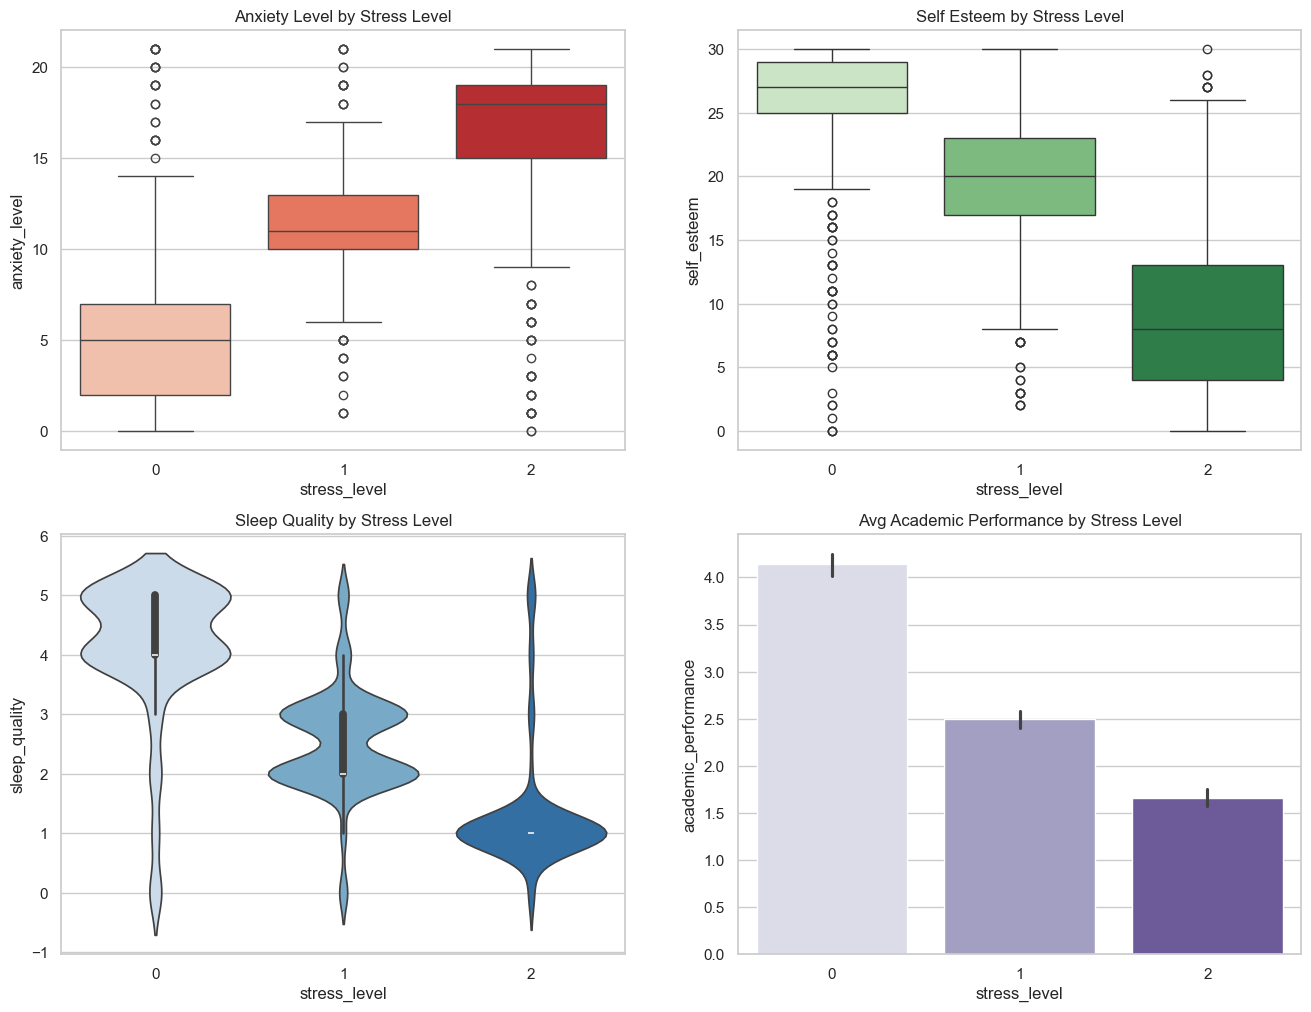

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Anxiety vs Stress
sns.boxplot(x='stress_level', y='anxiety_level', data=df, ax=axes[0, 0], palette='Reds')
axes[0, 0].set_title('Anxiety Level by Stress Level')

# Self Esteem vs Stress
sns.boxplot(x='stress_level', y='self_esteem', data=df, ax=axes[0, 1], palette='Greens')
axes[0, 1].set_title('Self Esteem by Stress Level')

# Sleep Quality vs Stress
sns.violinplot(x='stress_level', y='sleep_quality', data=df, ax=axes[1, 0], palette='Blues')
axes[1, 0].set_title('Sleep Quality by Stress Level')

# Academic Performance vs Stress
sns.barplot(x='stress_level', y='academic_performance', data=df, ax=axes[1, 1], palette='Purples')
axes[1, 1].set_title('Avg Academic Performance by Stress Level')

plt.show()


## 5. Feature Importance Analysis
To objectively rank the features, we will use a Random Forest Classifier to derive feature importances. This helps in understanding which factors are the strongest predictors of stress.


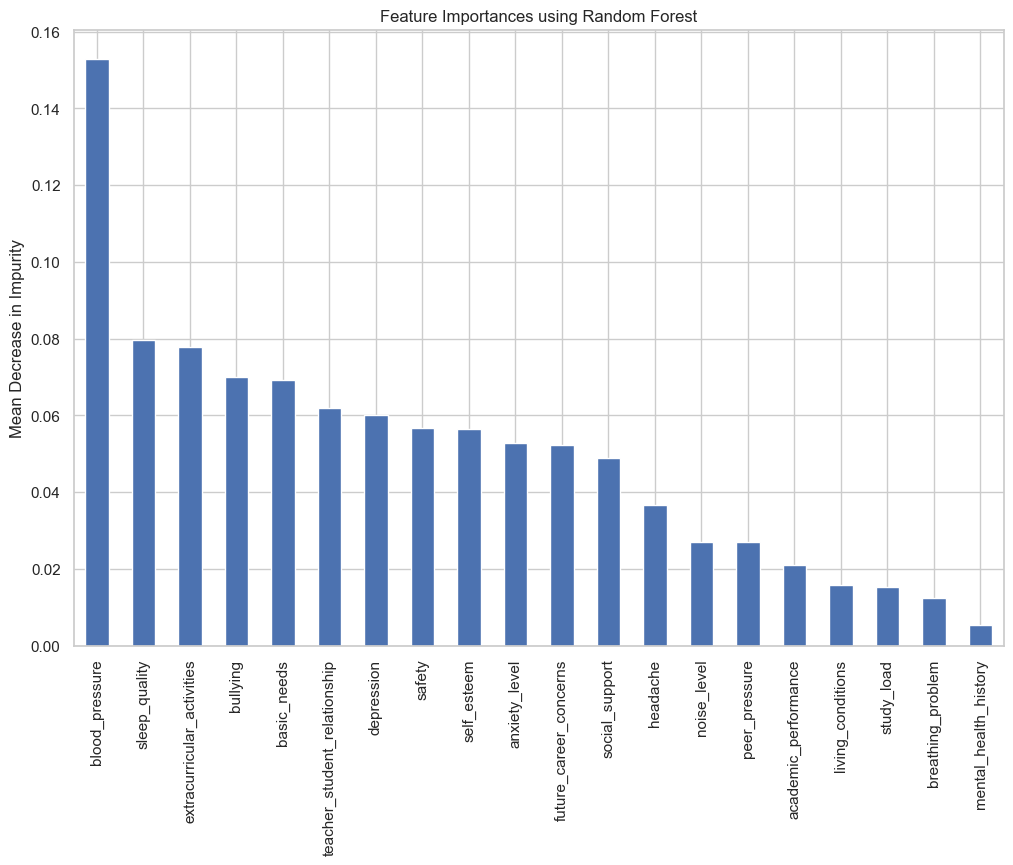

Key Observations:
blood_pressure                0.152873
sleep_quality                 0.079592
extracurricular_activities    0.077841
bullying                      0.070069
basic_needs                   0.069203
dtype: float64


In [8]:
X = df.drop('stress_level', axis=1)
y = df['stress_level']

# Split data (just for fitting the importance model)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get Importances
importances = rf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))
forest_importances.plot.bar()
plt.title("Feature Importances using Random Forest")
plt.ylabel("Mean Decrease in Impurity")
plt.show()

print("Key Observations:")
print(forest_importances.head(5))


## 6. Conclusion and Insights

Based on our comprehensive EDA and Feature Importance analysis:

1.  **Dominant Predictors:** The Random Forest model indicates that **Sleep Quality** and **Headache** frequency are the most critical determinants of stress, followed closely by **Bullying** and **Extracurricular Activities**.
2.  **Psychological vs. Physiological:** While psychological factors like Anxiety are highly correlated, physiological indicators (Sleep, Headache) appear to have slightly higher predictive power in the model.
3.  **Social Environment:** **Bullying** emerges as a major social stressor (0.75 correlation), significantly impacting student well-being.
4.  **Recommendations:**
    *   **Sleep Hygiene Campaigns:** Given the importance of sleep quality, schools should focus on education regarding sleep habits.
    *   **Anti-Bullying Programs:** Addressing bullying could yield substantial reductions in high-stress cases.
    *   **Holistic Monitoring:** Regular checks on "Headache" frequency could serve as an early warning system for somatic stress symptoms.

This dataset provides a robust foundation for building high-accuracy predictive models.
